# Identifying Suitable Location for your Business Expansion

## 1. Introduction:

### 1.1 Background:
Your friend is running coffee shop business for past few years in different states of U.S. As a company, they felt that itss time to expand their business. They selected for e.g., Los Angeles, CA city as the location of expansion. Their business model only cares about different neighborhoods in this city which are less competitive in nature along with their proximity to the city/county (assumption). This type of business model worked for them in all their previous scenarios. They thought data can provide solution to their problem. As an experienced data scientist, they approached you for this task.
### 1.2 Business Problem:
The primary business problem you as a data scientist needs to solve is:
Given a county/city, you have to look for different neighborhoods in this county/city with comparatively small number of coffee shops in them, identify neighborhoods that are in close proximity to the city/county and recommend these neighborhoods to the company team. This helps the company to expand their presence accordingly to their business model.


In [1]:
import pandas as pd
import numpy as np
import geocoder
import requests
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
import geopy.distance

from geopy.geocoders import Nominatim
from bs4 import BeautifulSoup
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

print("Libraries imported.")

Libraries imported.


## 2. Data:

### 2.1 Data Source:
All the neighborhoods that are located in Los Angeles, CA are taken from a Wikipedia page [\[1\]](https://en.wikipedia.org/wiki/List_of_districts_and_neighborhoods_in_Los_Angeles). This page has total of 200 neighborhoods. We use these neighborhoods as a starting point for our project. As all this data only has names of the neighborhoods, to continue we need to extract more information.

In [2]:
class PrepareData:
    def __init__(self, url, address):
        self.url = url
        self.df = ""
        self.address = address
        self.nearby_venues = ""
    def get_data(self, file_name="df_initial.csv"):
        data = requests.get(self.url).text
        soup = BeautifulSoup(data, "html.parser")
        print(f"Getting Data from URL: \n{self.url}")
        neighbors_LA = [] 
        for item in soup.find_all('div', class_='div-col'):
            cur_item = [neighbor.find('a').text for neighbor in item.find_all('li') if neighbor.find('a').text[0]!='[']
            neighbors_LA += cur_item
        self.df = pd.DataFrame(neighbors_LA, columns=['Neighborhood'])
        latitude, longitude = self.get_lat_lng(self.df)
        self.df['Latitude'] = latitude
        self.df['Longitude'] = longitude
        distances = self.get_distance_from_city(self.df)
        self.df['Distance'] = distances
        print("Data successfully loaded!!!")
        print("\nSaving data to disk")
        self.write_data_to_disk(file_df=self.df, file_name=file_name)
    
    def get_distance_from_city(self, df_la):
        city_coords = self.get_address_lat_lng()
        distances = []
        for neighbor_coords in zip(df_la['Latitude'], df_la['Longitude']):
            distances.append(geopy.distance.geodesic(city_coords, neighbor_coords).miles)
        return distances
    
    def write_data_to_disk(self, file_df=None, file_name=""):
        file_df.to_csv(file_name, index=False)
        print(f"Data successfully saved to disk with name as {file_name}!!!")
    def manually_load_initial_df(self, dataframe):
        self.df = dataframe
        print("Dataframe successfully loaded to class attribute, 'self.df'")
    def manually_load_venues_df(self, dataframe):
        self.nearby_venues = dataframe
        print("Dataframe successfully loaded to class attribute, 'self.nearby_venues'")
    def get_lat_lng(self, df_la):
        latitude = []
        longitude = []
        for neighborhood in df_la['Neighborhood']:
            lat_lng_coords = None
            while lat_lng_coords is None:
                g = geocoder.arcgis('{}, Los Angeles, CA'.format(neighborhood))
                lat_lng_coords = g.latlng
            latitude.append(lat_lng_coords[0])
            longitude.append(lat_lng_coords[1])
        return latitude, longitude
    
    def get_address_lat_lng(self):
        geolocator = Nominatim(user_agent="la_explorer")
        location = geolocator.geocode(self.address)
        latitude = location.latitude
        longitude = location.longitude
        return latitude, longitude
        
    def visualize_on_map(self):
        latitude, longitude = self.get_address_lat_lng()
        print('The geograpical coordinate of {} are {}, {}.'.format(self.address, latitude, longitude))
        # create map of Los Angeles using latitude and longitude values
        map_la = folium.Map(location=[latitude, longitude], zoom_start=10)

        # add markers to map
        for lat, lng, neighborhood in zip(self.df['Latitude'], self.df['Longitude'], self.df['Neighborhood']):
            label = '{}, {}'.format(neighborhood, self.address)
            label = folium.Popup(label, parse_html=True)
            folium.CircleMarker(
                [lat, lng],
                radius=5,
                popup=label,
                color='blue',
                fill=True,
                fill_color='#3186cc',
                fill_opacity=0.7,
                parse_html=False).add_to(map_la)  

        return map_la
    
    def load_credentials(self, file_path):
        with open(file_path, 'r') as f:
            lst = f.read().split('\n')
        CLIENT_ID = lst[0].split('=')[-1] # your Foursquare ID
        CLIENT_SECRET = lst[1].split('=')[-1] # your Foursquare Secret
        VERSION = '20180605' # Foursquare API version
        LIMIT = 100 # A default Foursquare API limit value
        return CLIENT_ID, CLIENT_SECRET, VERSION, LIMIT
    
    def get_nearby_venues(self, credentials_path='credentials.txt', radius=500):
        venues_list=[]
        CLIENT_ID, CLIENT_SECRET, VERSION, LIMIT = self.load_credentials(credentials_path)
        print("FourSquare API Credentials loaded successfully!")
        print("\nStarted extracting nearby venues data from FourSquare API:")
        for name, lat, lng, dist in zip(self.df['Neighborhood'], self.df['Latitude'], self.df['Longitude'], self.df['Distance']):
            # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                lat, 
                lng, 
                radius, 
                LIMIT)

            # make the GET request
            results = requests.get(url).json()["response"]['groups'][0]['items']

            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng,
                dist,
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])

        self.nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        self.nearby_venues.columns = ['Neighborhood', 
                      'Latitude', 
                      'Longitude',
                      'Distance',
                      'Venue', 
                      'Venue Latitude', 
                      'Venue Longitude', 
                      'Venue Category']
        print("Successfully Extracted!!!")
        print("\nSaving data to disk")
        self.write_data_to_disk(file_df=self.nearby_venues, file_name='df_nearby_venues.csv')

In [3]:
url = "https://en.wikipedia.org/wiki/List_of_districts_and_neighborhoods_in_Los_Angeles"
address = "Los Angeles, CA"
data_prep = PrepareData(url, address)

### 2.2 Data Extraction:
Firstly, all the neighborhood locations in the page can be extracted using Python’s BeautifulSoup library. For each neighborhood, we extract its latitude and longitude values using geocoder library. Additionally, we also compute distance from city/county (Los Angeles, CA in this example) to each neighborhood in miles using geopy library.  An initial dataframe is created with ‘Neighborhood’, ‘Latitude’, ‘Longitude’ and ‘Distance’ as its columns.

In [4]:
data_prep.get_data()

Getting Data from URL: 
https://en.wikipedia.org/wiki/List_of_districts_and_neighborhoods_in_Los_Angeles
Data successfully loaded!!!

Saving data to disk
Data successfully saved to disk with name as df_initial.csv!!!


The top 5 rows of dataframe would look like this:

In [4]:
df_la = pd.read_csv("df_initial.csv")
df_la.head()

,Neighborhood,Latitude,Longitude,Distance
0,Angelino Heights,34.070290,-118.254800,1.336214
1,Angeles Mesa,2.421100,-76.917380,3438.698701
2,Angelus Vista,34.087575,-118.267156,2.722398
3,Arleta,34.249050,-118.433490,17.342378
4,Arlington Heights,34.039890,-118.325160,4.822006


In [5]:
data_prep.manually_load_initial_df(df_la)

Dataframe successfully loaded to class attribute, 'self.df'


### Visualization of Neighborhoods on Map using Folium
To visualize geographic details of above neighborhoods on map, we use folium library in Python. I created a map of Los Angeles, CA using its latitude and longitude values. Then, I added markers to this map for each neighborhood location from the dataframe using its latitude and longitude values.

In [7]:
data_prep.visualize_on_map()

The geograpical coordinate of Los Angeles, CA are 34.0536909, -118.242766.


### Extracting Nearby Venues using FourSquare API:
Secondly, we use FourSquare API to extract nearby venues data for each neighborhood in the initial dataframe. To elaborate on FourSquare API, it explores the neighborhood by taking its name, latitude and longitude information along with the user credentials like Client ID and Access Token in extracting the venues that are nearby to the given neighborhood. It is mainly used to access the venues information like venue name, venue location (both latitude and longitude of the venue) and venue category. All this data is combined to form a new dataframe with columns as ‘Neighborhood’, ‘Latitude’, ‘Longitude’, ‘Distance’, ‘Venue’, ‘Venue Latitude’, ‘Venue Longitude’ and ‘Venue Category’.

In [8]:
data_prep.get_nearby_venues(credentials_path='credentials.txt')

FourSquare API Credentials loaded successfully!

Started extracting nearby venues data from FourSquare API:
Successfully Extracted!!!

Saving data to disk
Data successfully saved to disk with name as df_nearby_venues.csv!!!


After all this extraction, the tail of the dataframe would look like below:

In [6]:
df_venues = pd.read_csv("df_nearby_venues.csv")
df_venues.tail()

,Neighborhood,Latitude,Longitude,Distance,Venue,Venue Latitude,Venue Longitude,Venue Category
4604,Yucca Corridor,34.10392,-118.33,6.084109,Hollywood Burger,34.100978,-118.325924,American Restaurant
4605,Yucca Corridor,34.10392,-118.33,6.084109,Dream Hollywood,34.099879,-118.330173,Hotel
4606,Yucca Corridor,34.10392,-118.33,6.084109,Trejo's Cantina,34.099513,-118.329077,Mexican Restaurant
4607,Yucca Corridor,34.10392,-118.33,6.084109,Mamas Shelter Restaurant,34.099590,-118.331391,Lounge
4608,Yucca Corridor,34.10392,-118.33,6.084109,Wood & Vine,34.101533,-118.326315,American Restaurant


In [7]:
data_prep.manually_load_venues_df(df_venues)

Dataframe successfully loaded to class attribute, 'self.nearby_venues'


## 3. Methodology
We extracted all the data that is required to predict the most suitable neighborhoods for our business expansion. Now, we need to proceed with further steps to make actual prediction.

In [28]:
class PredictNeighborhood:
    def __init__(self, df, city):
        self.df = df
        self.city = city
        self.onehot_df = self.make_onehot()
        self.clustered_df = "Later, this will be assigned with a pandas DF"
        self.n_clusters = 3
        
    def make_onehot(self):
        print("Creating onehot encoding of venues dataframe:")
        # one hot encoding
        onehot = pd.get_dummies(self.df[['Venue Category']], prefix="", prefix_sep="")
        
        # add neighborhood column back to dataframe
        onehot['Neighborhood'] = self.df['Neighborhood']
        
        # move neighborhood column to the first column
        onehot_neighborhood = onehot.pop('Neighborhood')
        onehot.insert(0, 'Neighborhood', onehot_neighborhood)
        print('Successfully onehot encoded the venues dataframe!!!')
        return onehot
        
    def plot_elbow_curve(self, col):
        if col not in self.df['Venue Category'].tolist():
            raise Exception(f"Column {col} is not found in Venues Category")
        onehot_grouped = self.onehot_df.groupby('Neighborhood').mean().reset_index()
        sub_df = onehot_grouped[['Neighborhood', col]]
        
        # set number of clusters
        X = sub_df.drop('Neighborhood', 1)
        
        inertias = []
        mapping2 = {}
        K = range(1, 10)
        sub_df = onehot_grouped[['Neighborhood', col]]
        # set number of clusters
        X = sub_df.drop('Neighborhood', 1)
        for k in K:
            # run k-means clustering
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=50).fit(X)
            inertias.append(kmeans.inertia_)
            mapping2[k] = kmeans.inertia_
        plt.plot(K, inertias, 'bx-')
        plt.xlabel('Values of K')
        plt.ylabel('Inertia')
        plt.title('The Elbow Method using Inertia')
        plt.show()
    
    
    def apply_clustering(self, col, rs, kclusters):
        if col not in self.df['Venue Category'].tolist():
            raise Exception(f"Column {col} is not found in Venues Category")
        print(f"Looks like you want to start a new {col} and searching for the less competetive neighborhood in {self.city}...")
        print(f"\nClustering the onehot encoded dataframe to {kclusters} clusters")
        self.n_clusters = kclusters
        onehot_grouped = self.onehot_df.groupby('Neighborhood').mean().reset_index()
        sub_df = onehot_grouped[['Neighborhood', col]]
        
        # set number of clusters
        X = sub_df.drop('Neighborhood', 1)

        # run k-means clustering
        kmeans = KMeans(n_clusters=kclusters, random_state=rs, n_init=50).fit(X)

        sub_df.insert(0, 'Cluster Labels', kmeans.labels_)
        self.clustered_df = sub_df.set_index('Neighborhood').join(self.df[self.df.columns[:4]].drop_duplicates().set_index('Neighborhood'), on='Neighborhood')
#         self.clustered_df.rename(columns={"Neighborhood Latitude": "Latitude", "Neighborhood Longitude": "Longitude"}, inplace=True)
        self.clustered_df.dropna(subset=['Cluster Labels'], inplace=True)
        self.clustered_df.reset_index(drop=False, inplace=True)
        self.clustered_df = self.clustered_df.astype({'Cluster Labels':'int32'})
        print("Clustering completed!!!")
        print('\nSaving data to disk')
        self.write_data_to_disk(file_df=self.clustered_df, file_name='df_clustered.csv')
        
    def write_data_to_disk(self, file_df=None, file_name=""):
        file_df.to_csv(file_name, index=False)
        print(f"Data successfully saved to disk with name as {file_name}!!!")
        
    def manually_load_clustered_df(self, dataframe):
        self.clustered_df = dataframe
        print("Dataframe successfully loaded to class attribute, 'self.clustered_df'")
        
    def manually_load_venues_df(self, dataframe):
        self.df = dataframe
        print("Dataframe successfully loaded to class attribute, 'self.df'")
        
    def visualize_cluster_map(self):
        geolocator = Nominatim(user_agent="la_explorer")
        location = geolocator.geocode(self.city)
        latitude = location.latitude
        longitude = location.longitude
        
        # create map
        map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

        # set color scheme for the clusters
        x = np.arange(kclusters)
        ys = [i + x + (i*x)**2 for i in range(kclusters)]
        colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
        rainbow = [colors.rgb2hex(i) for i in colors_array]

        # add markers to the map
        markers_colors = []
        for lat, lon, poi, cluster in zip(self.clustered_df['Latitude'], self.clustered_df['Longitude'], 
                                          self.clustered_df['Neighborhood'], self.clustered_df['Cluster Labels']):
            label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
            folium.CircleMarker(
                [lat, lon],
                radius=5,
                popup=label,
                color=rainbow[cluster-1],
                fill=True,
                fill_color=rainbow[cluster-1],
                fill_opacity=0.7).add_to(map_clusters)
        return map_clusters
    
    def visualize_cluster_barcharts(self, n_top_venues=5):
        onehot_grouped = self.onehot_df.groupby('Neighborhood').mean().reset_index()
        onehot_grouped_top_venues = self.get_most_common_venues(onehot_grouped, n_top_venues)
        clust_df = onehot_grouped_top_venues.join(
            self.clustered_df[['Neighborhood', 'Cluster Labels']].set_index('Neighborhood'), on="Neighborhood"
        )
        clust_df.dropna(subset=['Cluster Labels'], inplace=True)
        clust_df.reset_index(drop=True, inplace=True)
        clust_df = clust_df.astype({'Cluster Labels':'int32'})
        clust_labels = clust_df.pop('Cluster Labels')
        clust_df.insert(1, "Cluster Labels", clust_labels)
        clusters = []
        for i in range(self.n_clusters):
            clusters.append(clust_df.loc[clust_df['Cluster Labels']==i, clust_df.columns[2:]])
        rows, cols = len(clusters)//2+1, 2
        fig, axs = plt.subplots(rows, cols, figsize=(15, 9))
        if len(clusters)%2 != 0:
            axs[len(clusters)//2, 1].set_visible(False)
        graphs = 0
        for i in range(rows):
            for j in range(cols):
                if graphs==len(clusters):
                    break
                cur_clust_cols = clusters[graphs].columns
                venue_types = []
                for col in cur_clust_cols:
                    venue_types += clusters[graphs][col].tolist()
                venue_types = np.array(venue_types)
                venue_types_cnt = np.unique(venue_types, return_counts=True)
                venue_types_cnt = [(venue, cnt) for venue, cnt in zip(*venue_types_cnt)]
                venue_types_cnt = sorted(venue_types_cnt, key=lambda x: x[-1], reverse=True)[:n_top_venues]
                bars = []
                cnts = []
                for k, v in venue_types_cnt:
                    bars.append(k)
                    cnts.append(v)
                y_pos = np.arange(len(bars))
                axs[i, j].barh(y_pos, cnts, color=['red', 'green', 'blue', 'orange', 'pink'], alpha=0.6)
                axs[i, j].set_yticks(y_pos)
                axs[i, j].set_yticklabels(bars)
                axs[i, j].invert_yaxis()
                axs[i, j].set_ylabel('Top Venues')
                axs[i, j].set_xlabel('No. of Venues')
                axs[i, j].set_title(f"Cluster {graphs}")
                graphs += 1
        fig.tight_layout()
        plt.show()
        
    def get_viable_neighborhoods(self, n_neighborhoods, n_top_venues=5):
        if n_neighborhoods > len(self.clustered_df):
            raise Exception("Please reduce the number of nieghbourhoods you want to retrieve")
        print("Looking for viable neighborhoods for your new business...")
        sorted_pred = self.clustered_df.sort_values(by=[col, 'Distance']).reset_index(drop=True)
        freq_cnt = np.unique(np.array(sorted_pred[col].tolist()), return_index=True, return_counts=True)
        freq_cnt_upd = []
        for val, idx, cnt in zip(*freq_cnt):
            freq_cnt_upd.append((val, idx, cnt))
        freq_cnt_upd = sorted(freq_cnt_upd, reverse=True, key=lambda x: x[-1])
        num_cnt = 0
        idxs = []
        for item in freq_cnt_upd:
            if num_cnt < n_neighborhoods:
                add_end = item[-1] if item[-1]-1 < n_neighborhoods-num_cnt else n_neighborhoods-num_cnt
                idxs.append((item[1], item[1]+add_end))
                num_cnt += add_end
        iloc_idxs = [i for item in idxs for i in range(*item)]
        viable_df1 = sorted_pred.iloc[iloc_idxs]
        viable_dict = {k:[v, d] for k, v, d in zip(viable_df1['Neighborhood'], viable_df1['Cluster Labels'], viable_df1['Distance'])}
        onehot_grouped = self.onehot_df.groupby('Neighborhood').mean().reset_index()
        rows = [True if item in viable_dict else False for item in onehot_grouped['Neighborhood']]
        viable_df = onehot_grouped.loc[rows]
        viable_neighborhoods = self.get_most_common_venues(viable_df, n_top_venues)
        viable_neighborhoods.insert(1, 'Cluster Labels', "")
        viable_neighborhoods.insert(2, 'Distance', "")
        print(f"Here are my {n_neighborhoods} recommendations: ")
        for k, v in viable_dict.items():
            print(f"\t\tNeighborhood: {k} (Cluster {v[0]}), Distance from City/County = {round(v[1], 2)} Miles")
            viable_neighborhoods['Cluster Labels'][viable_neighborhoods['Neighborhood']==k] = v[0]
            viable_neighborhoods['Distance'][viable_neighborhoods['Neighborhood']==k] = v[-1]
        return viable_neighborhoods.sort_values(by=['Distance']).reset_index(drop=True)
    
    def return_most_common_venues(self, row, num_top_venues):
        row_categories = row.iloc[1:]
        row_categories_sorted = row_categories.sort_values(ascending=False)

        return row_categories_sorted.index.values[0:num_top_venues]
    
    def get_most_common_venues(self, viable_df, num_top_venues):
        indicators = ['st', 'nd', 'rd']
        
        # create columns according to number of top venues
        columns = ['Neighborhood']
        for ind in np.arange(num_top_venues):
            try:
                columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
            except:
                columns.append('{}th Most Common Venue'.format(ind+1))

        # create a new dataframe
        neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
        neighborhoods_venues_sorted['Neighborhood'] = viable_df['Neighborhood']

        for ind in np.arange(viable_df.shape[0]):
            neighborhoods_venues_sorted.iloc[ind, 1:] = self.return_most_common_venues(viable_df.iloc[ind, :], num_top_venues)

        return neighborhoods_venues_sorted
    

### 3.1 Onehot Encoding:
We are looking for different neighborhoods identifying venue categories of type Coffee Shops that are present closer to Los Angeles, CA in estimating our prediction. The venue categories here are the text labels. For any machine learning model to extract meaningful information from these text labels, we need to make them onehot encoded. In this step, we onehot encode all our venue categories of type text labels before passing them to any model. I made use of pandas library to serve this purpose.

In [29]:
col = 'Coffee Shop'
address = "Los Angeles, CA"
battle_begins = PredictNeighborhood(df_venues, address)

Creating onehot encoding of venues dataframe:
Successfully onehot encoded the venues dataframe!!!


A part of the head of the onehot encoded dataframe would look like this:

In [13]:
battle_begins.onehot_df.head()

,Neighborhood,ATM,Acai House,Accessories Store,Adult Boutique,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,...,Warehouse Store,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Yoshoku Restaurant
0,Angelino Heights,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Angelino Heights,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Angelino Heights,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Angelino Heights,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Angelino Heights,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 3.2 Model Selection:
Clustering is one better type of technique which we can use in identifying the neighborhoods. The main idea here is that given the venue category (coffee shops in our e.g.) on which we want to cluster, the clustering technique ensures that the neighborhoods are clustered to the given number of clusters based on number of coffee shops available in each neighborhood. All the neighborhoods with fewer coffee shops would be made into a cluster. Now, we can extract required number of neighborhoods from these clusters with fewer coffee shops, also identifying those neighborhoods with in close proximity to the city/county and recommend them to our company for their business expansion.

### K-Means Clustering: 
We will be using K-Means clustering implementation from scikit-learn library. ‘K’ in K-Means clustering represents the number of clusters we want to create. 

For efficient model, we need to identify more optimal value for this ‘k’ i.e., we need to identify more optimal number of clusters for our data.
### Identifying Optimal ‘K’ Value:
Elbow method [\[2\]](https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/) comes to our rescue in identifying more optimal value for ‘k’. The elbow method identifies this value by plotting different values of ‘k’ with its respective sum of squared distances of samples to their closest cluster center. To determine the optimal number of clusters, we have to select the value of ‘k’ at the “elbow” i.e., the point after which the sum of squared distances start decreasing in a linear fashion.

In our case, as shown in figure below, it turns out that the more optimal value for ‘k’ would be 3. So, we divide our data to 3 clusters (Cluster 0, 1 & 2) based on the range of number of coffee shops in each neighborhood.

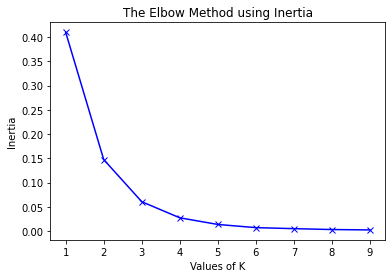

In [14]:
battle_begins.plot_elbow_curve(col)

In [125]:
# From above elbow curve, we can see that optimium value for kclusters=3 
kclusters = 3
battle_begins.apply_clustering(col, 36, kclusters)

Looks like you want to start a new Coffee Shop and searching for the less competetive neighborhood in Los Angeles, CA...

Clustering the onehot encoded dataframe to 3 clusters
Clustering completed!!!

Saving data to disk
Data successfully saved to disk with name as df_clustered.csv!!!


In [126]:
df_clustered = pd.read_csv("df_clustered.csv")
df_clustered.head()

,Neighborhood,Cluster Labels,Coffee Shop,Latitude,Longitude,Distance
0,Angelino Heights,1,0.040000,34.070290,-118.254800,1.336214
1,Angelus Vista,1,0.100000,34.087575,-118.267156,2.722398
2,Arleta,0,0.000000,34.249050,-118.433490,17.342378
3,Arlington Heights,1,0.090909,34.039890,-118.325160,4.822006
4,Arts District,1,0.090909,34.041964,-118.236387,0.887268


In [17]:
battle_begins.manually_load_clustered_df(df_clustered)

Dataframe successfully loaded to class attribute, 'self.clustered_df'


## 4. Results

### 4.1 Visualization of Clusters on Map using Folium:
To visualize geographic details of created clusters on map, we use folium library in Python. I created a map of Los Angeles, CA using its latitude and longitude values. Then, I added markers to this map for each neighborhood location using its latitude and longitude values with each cluster assigned to a different color.

In [18]:
battle_begins.visualize_cluster_map()

### 4.3 Neighborhood Identification for Business Expansion:
In the below figure, we can see that my model predicted 5 neighborhoods in the order of their distance to the city/county. Please note that all the neighborhoods belong to Cluster 0 which does not have venue category of Coffee Shop in its top 10 venues list.

In [129]:
winning_neighborhoods = battle_begins.get_viable_neighborhoods(n_neighborhoods=5, n_top_venues=10)

Looking for viable neighborhoods for your new business...
Here are my 5 recommendations: 
		Neighborhood: Solano Canyon (Cluster 0), Distance from City/County = 2.0 Miles
		Neighborhood: Elysian Park (Cluster 0), Distance from City/County = 2.06 Miles
		Neighborhood: Boyle Heights (Cluster 0), Distance from City/County = 2.08 Miles
		Neighborhood: Lincoln Heights (Cluster 0), Distance from City/County = 2.1 Miles
		Neighborhood: Wilshire Park (Cluster 0), Distance from City/County = 2.14 Miles


The below data frame gives the complete look into the recommended neighborhoods along with their cluster labels, distance from city/county and their top 10 most common venues.

In [130]:
winning_neighborhoods

,Neighborhood,Cluster Labels,Distance,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Solano Canyon,0,2.004575,Playground,Baseball Field,Park,Basketball Court,Disc Golf,Noodle House,Paper / Office Supplies Store,Pet Store,Pet Service,Peruvian Restaurant
1,Elysian Park,0,2.060077,Park,Playground,Disc Golf,ATM,Peruvian Restaurant,Persian Restaurant,Performing Arts Venue,Pedestrian Plaza,Paper / Office Supplies Store,Outdoors & Recreation
2,Boyle Heights,0,2.076601,Grocery Store,ATM,Video Store,Ice Cream Shop,Fast Food Restaurant,Pizza Place,Cosmetics Shop,Café,Sushi Restaurant,Bank
3,Lincoln Heights,0,2.103666,Mexican Restaurant,Convenience Store,Fried Chicken Joint,Burger Joint,Music Venue,Fast Food Restaurant,Food Truck,Sandwich Place,Pizza Place,Outdoor Sculpture
4,Wilshire Park,0,2.137273,Latin American Restaurant,Fast Food Restaurant,Karaoke Bar,Mexican Restaurant,Korean Restaurant,Park,Chinese Restaurant,Theater,Seafood Restaurant,Convenience Store


## 5. Discussion

### 5.1 Bar Chart Visualization:
Let us visualize the top venue categories in each cluster using a bar chart.

In these bar charts, we can see that Coffee Shop is one of the top 10 venue categories in both Cluster 1 and Cluster 2. The Coffee Shop does not make into the list of top 10 venue categories in Cluster 0. Thus, our most of the recommended neighborhoods are from Cluster 0 and are in close proximity to the city/county.

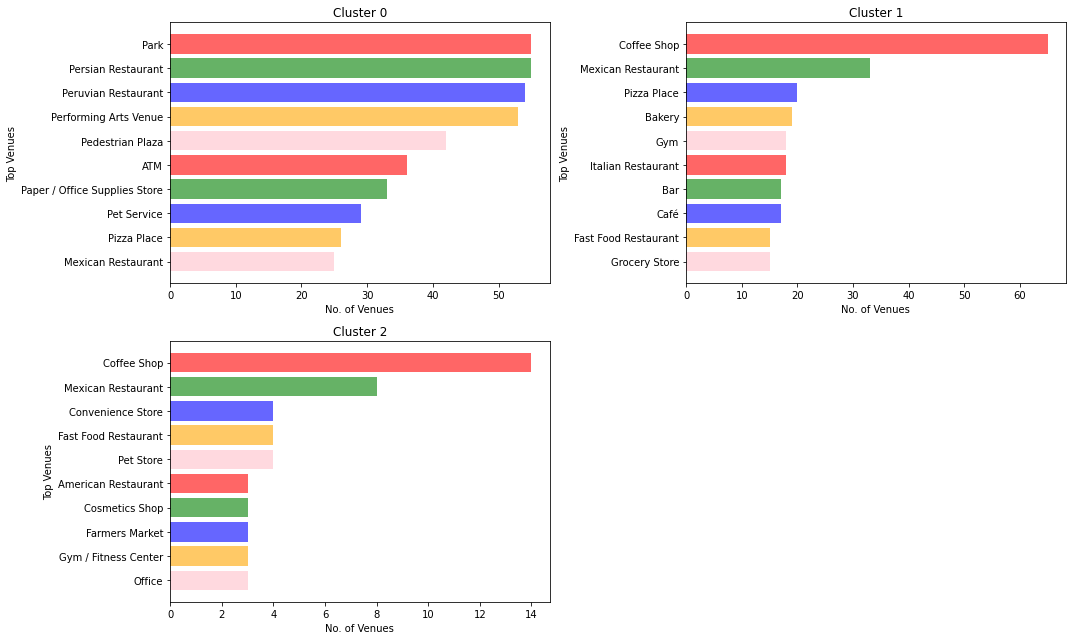

In [131]:
battle_begins.visualize_cluster_barcharts(n_top_venues=10)

Additionally, my code is more generic and works for any venue category by passing the required venue category while applying clustering. For neighborhood prediction, we can pass variable number of neighborhoods we are looking for and my code ensures that all the required conditions are met and return these neighborhoods. With respect to bar chart visualizations, we can pass variable number of top venues that we want to plot. 

In this example, I limited number of clusters to 3, venue category to ‘Coffee Shop’, number of neighborhoods to recommend to 5 and number of top venues to 10 for bar chart visualization.

## 6. Conclusion

In this project considering myself as a Data Scientist, I recommended the neighborhoods for a company who wants to expand their Coffee Shop business in Los Angeles, CA. I used K-Means clustering technique to identify three different clusters of neighborhoods based on the range of number of coffee shops in each neighborhood. Finally, after meeting all the required conditions that the company has mentioned I recommended five neighborhoods. These five neighborhoods are in close proximity to the Los Angeles, CA in comparison to the other neighborhoods of the same cluster. The effectiveness of these recommendations has been verified by plotting the top ten venues of all the clusters using a bar chart. Appropriate visualizations are also provided whereever required in the project.

## 7. References

1. https://en.wikipedia.org/wiki/List_of_districts_and_neighborhoods_in_Los_Angeles
2. https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/
3. https://developer.foursquare.com/